# Autoencoder: Ejemplo fashion MNIST
---
**Giovanny Alejandro Cuervo Londoño**

Cree un autoencoder para el conjunto de datos Fashion MNIST, usando una red convolucional. Los datos puede obtenerlos directamente en keras como se hizo el conjunto MNIST de digitos. Revise el enlace.

* **0. Importamos los paquetes necesarios** 

In [2]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

In [3]:
print('Numpy', np.__version__)
print('Pandas', pd.__version__)
print('Tensorflow', tf.__version__)


Numpy 1.19.5
Pandas 1.1.5
Tensorflow 2.4.1


Este notebook se hizo con las librerías
> Numpy 1.19.5

> Pandas 1.1.5

> Seaborn 0.11.1

> Tensor Flow 2.4.1

* **0. Funciones Necesarias definidas** 

In [4]:
def get_key(my_dict, val):
    for key, value in my_dict.items():
         if val == value:
             return key

## I. Autoencoder Red Convolucional
### Fashion MNIST
---

* **1. Cargamos los datos y las etiquetas objetivo**

In [5]:
from tensorflow import keras

(X_train, y_train), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [6]:
print(f'Datos entreno {X_train.shape} y evaluación {X_test.shape} tipo: {type(X_train), type(X_test)}\nEtiquetas(número) de entreno: {y_train.shape} y evaluación {y_test.shape} y tipo: {(type(y_train), type(y_test))}')

Datos entreno (60000, 28, 28) y evaluación (10000, 28, 28) tipo: (<class 'numpy.ndarray'>, <class 'numpy.ndarray'>)
Etiquetas(número) de entreno: (60000,) y evaluación (10000,) y tipo: (<class 'numpy.ndarray'>, <class 'numpy.ndarray'>)


In [7]:
labels = {'T-shirt/top': 0, 'Trouser' : 1, 'Pullover': 2, 'Dress': 3, 'Coat': 4, 'Sandal': 5, 'Shirt': 6, 'Sneaker': 7, 'Bag': 8, 'Ankle boot': 9}

* 1.1 Visualizamos los datos los datos

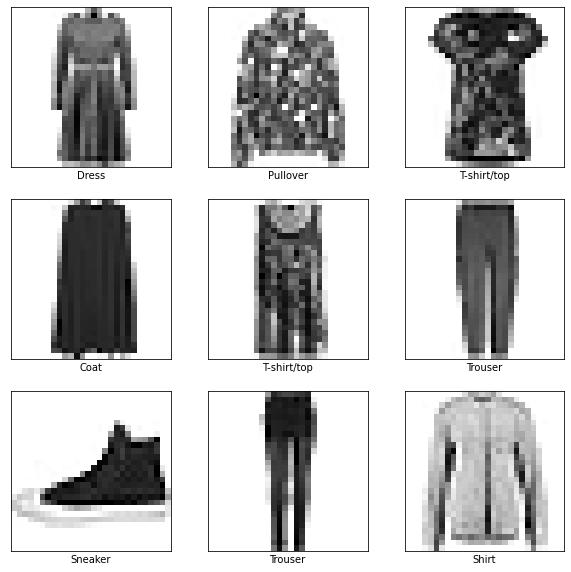

In [30]:
from numpy.random import randint
plt.figure(figsize=(10,10))

for idx, val in enumerate(randint(X_train.shape[0], size=9)):
    plt.subplot(3,3,idx+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[val], cmap=plt.cm.binary)
    plt.xlabel(get_key(labels, y_train[val]))
plt.show()

* **2. Preprocesamiento los datos**

In [9]:
# reshape para colocar los datos de entrenamiento en el fomato apropiado.
# Agrega una dimensión al final
train_images = X_train.reshape(60000, 28, 28, 1)
#normalizamos los px de las imagenes para que queden entre 0 y 1 
train_images = train_images / 255.0

# reshape para colocar los datos de test en el fomato apropiado. Agrega una dimensión al final y  normaliza los datos
test_images = X_test.reshape(10000, 28, 28, 1)
test_images = test_images/255.0

print("Nueva forma de los datos de entrenamiento:", train_images.shape)

Nueva forma de los datos de entrenamiento: (60000, 28, 28, 1)


In [10]:
print(f'Imagenes (train) preprocesadas \nvalor minimo: {train_images[0].min()} \nvalor max: {train_images[0].max()}')

Imagenes (train) preprocesadas 
valor minimo: 0.0 
valor max: 1.0


* **4. Definimos la arquitectura del encoder**

* 4.1 reducción de tamaño con conv2D

para entender como las convoluciones cofican la información al reducir su tamaño definimos una función 

> $n$ = input shape $(n, n, n_c)$ *rows $n$, cols $n$, canales $n_c$*

> $p$ = padding donde $p = \frac{f - 1}{2}$

> $k$ = kernel shape $(k, k, k_c)$ *rows $k$, cols $k$, canales $k_c$*

> $s$ =  1 stride o salto por defecto (1, 1)

In [11]:
def shape_after_conv(imput_shape, kernel_shape, n_kernels, padding = 'valid', stride = 1):
  """
  Esta funcion retorna el tamaño de los datos despues de una 
  convolucion.

  inputs:
  imput_shape = tupla shape del dato no de los datos
  kernel_shape = tupla shape del kernel
  padding = el tipo de padding utilizado 'same' o 'valid' (default)
  stride = salto del kernel por defecto en layers.conv2D es 1 (default)
  n_kernels = cantidad de kernels en layers.conv2D

  output
  nuevo shape de los datos despues de una convolucion
  """
  n = imput_shape[1]
  if padding == 'same':
    p = (kernel_shape[0] - 1)/2
  else:
    p = 0
  k = kernel_shape[0]
  s = stride
  floor = lambda n, p, k, s:  ((n + 2*p - k)/s) + 1
  shape_conv = (floor(n, p, k, s), floor(n, p, k, s), n_kernels)
  
  return shape_conv

In [12]:
#en esta celda exploramos como se contrae la informacion dependiendo de los parametros de la convolucion
input = (28, 28, 1)
filters = [4, 16, 32, 64] #Estos filtros van en potencias de dos 2**2 = 4, 2**4 = 16, 2**5 = 32, 2**6 =64
for i, filter in enumerate(filters):
  input = shape_after_conv(input, (3, 3), filter, stride=2, padding= 'valid')
  print(f'output conv{i+1}: {input}') #salen sin redondear

output conv1: (13.5, 13.5, 4)
output conv2: (6.25, 6.25, 16)
output conv3: (2.625, 2.625, 32)
output conv4: (0.8125, 0.8125, 64)


output inputs: (None, 28, 28, 1)
output conv1: (None, 14, 14, 4)
output conv2: (None, 7, 7, 16)
output conv3: (None, 4, 4, 32)
output conv4: (None, 2, 2, 64)
output flat: (None, 256)
output dense: (None, 64)
Model: "encoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 4)         40        
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 16)          592       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 32)          4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 2, 2, 64)          18496     
_________________________________________________

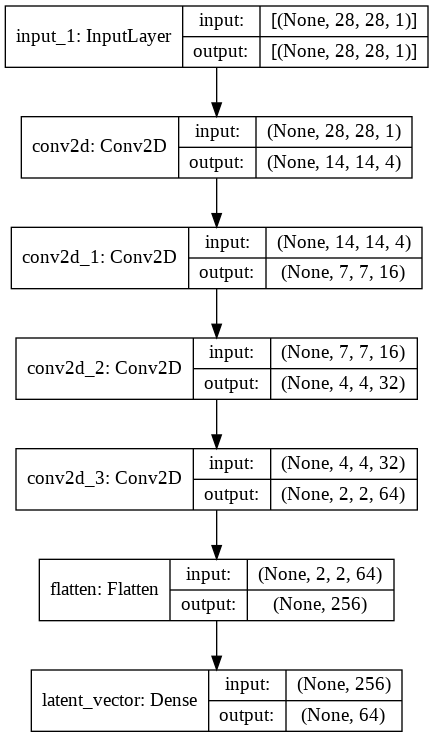

In [13]:
from tensorflow.keras.models import Model
from keras import layers, Input
from tensorflow.keras import utils

inputs = Input(shape =(28, 28, 1)) 
print(f'output inputs: {inputs.shape}')
#encoder
#input = 28 x 28 x 1 (wide and thin)
conv1 = layers.Conv2D(4, (3, 3), activation='relu', strides=(2,2),padding='same')(inputs) #14 x 14 x 4
print(f'output conv1: {conv1.shape}') #(None, 14, 14, 4)
conv2 = layers.Conv2D(16, (3, 3), activation='relu', strides=(2,2),padding='same')(conv1) #7 x 7 x 16
print(f'output conv2: {conv2.shape}') #(None, 7, 7, 16)
conv3 = layers.Conv2D(32, (3, 3), activation='relu', strides=(2,2),padding='same')(conv2) #4 x 4 x 32
print(f'output conv3: {conv3.shape}') #(None, 4, 4, 32)
conv4 = layers.Conv2D(64, (3, 3), activation='relu', strides=(2,2),padding='same')(conv3) #2 x 2 x 64

# Save the shape to the decoder
shape = conv4.shape#.as_list()
print(f'output conv4: {shape}') #(None, 2, 2, 64)
flat = layers.Flatten()(conv4)
print(f'output flat: {flat.shape}') #(None, 256

encoded = layers.Dense(shape[-1], name ='latent_vector')(flat) 
print(f'output dense: {encoded.shape}')
encoder = Model(inputs, encoded, name ='encoder')

encoder.summary()
utils.plot_model(encoder, show_shapes=True) 

* **5. Definimos la arquitectura del decoder**

output input: (None, 64)
output dense2: (None, 256)
output dense2 reshape: (None, 2, 2, 64)
output conv1_dec: (None, 4, 4, 32)
output conv2_dec: (None, 8, 8, 16)
output maxpool: (None, 7, 7, 16)
output conv3_dec: (None, 14, 14, 4)
output conv4_dec: (None, 28, 28, 1)
Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
decoder_input (InputLayer)   [(None, 64)]              0         
_________________________________________________________________
dense (Dense)                (None, 256)               16640     
_________________________________________________________________
reshape (Reshape)            (None, 2, 2, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 4, 4, 32)          18464     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 8, 8, 16)          4

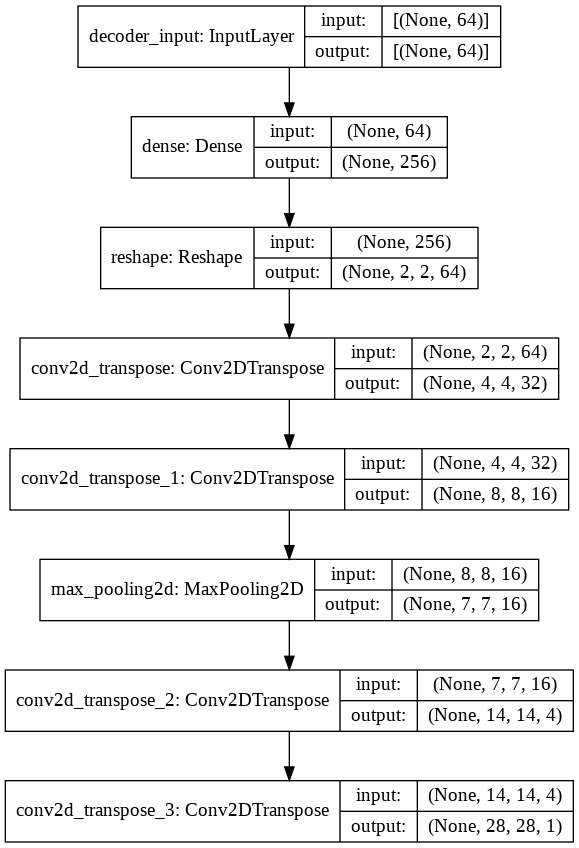

In [14]:
 
#decoder
encoded_inputs = Input(shape =(shape[-1],), name ='decoder_input') # (None, 64)
print(f'output input: {encoded_inputs.shape}')
latent_dec = layers.Dense(np.prod(shape[1:]))(encoded_inputs) # (None, 256)
print(f'output dense2: {latent_dec.shape}') 
reshape_dec = layers.Reshape((shape[1], shape[2], shape[3]))(latent_dec) # (None, 2, 2, 64)
print(f'output dense2 reshape: {reshape_dec.shape}')
conv1_dec = layers.Conv2DTranspose(32, (3, 3), activation='relu', strides=(2,2),padding='same')(reshape_dec) # (None, 4, 4, 32)
print(f'output conv1_dec: {conv1_dec.shape}')
conv2_dec = layers.Conv2DTranspose(16, (3, 3), activation='relu', strides=(2,2),padding='same')(conv1_dec) # (None, 8, 8, 16)
print(f'output conv2_dec: {conv2_dec.shape}')
maxpool = layers.MaxPool2D(pool_size=(2, 2), strides=(1, 1), padding='valid')(conv2_dec) # (None, 7, 7, 16)
print(f'output maxpool: {maxpool.shape}')
conv3_dec = layers.Conv2DTranspose(4, (3, 3), activation='relu', strides=(2,2),padding='same')(maxpool) # (None, 14, 14, 4)
print(f'output conv3_dec: {conv3_dec.shape}')
decoded = layers.Conv2DTranspose(1, (3, 3), activation='sigmoid', strides=(2,2),padding='same')(conv3_dec) # (None, 28, 28, 1)
print(f'output conv4_dec: {decoded.shape}')
decoder = Model(encoded_inputs, decoded, name ='decoder')

decoder.summary()
utils.plot_model(decoder, show_shapes=True)






* **6. Compilamos el modelo**

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
encoder (Functional)         (None, 64)                40216     
_________________________________________________________________
decoder (Functional)         (None, 28, 28, 1)         40345     
Total params: 80,561
Trainable params: 80,561
Non-trainable params: 0
_________________________________________________________________


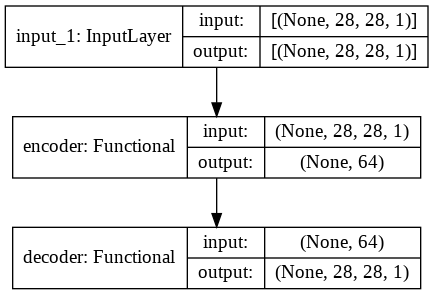

In [15]:
from tensorflow.keras import utils


#model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', 'mse'])
autoencoder = Model(inputs, decoder(encoder(inputs)))
autoencoder.compile(loss='mean_squared_error', optimizer = 'adam', metrics=['accuracy', 'mse'])

autoencoder.summary()
utils.plot_model(autoencoder, show_shapes=True)

In [20]:
history = autoencoder.fit(train_images, train_images, batch_size=128, epochs=50, shuffle=True, validation_data=(test_images,test_images))

Epoch 1/50
469/469 [==============================] - 4s 8ms/step - loss: 0.0079 - accuracy: 0.5093 - mse: 0.0079 - val_loss: 0.0080 - val_accuracy: 0.5071 - val_mse: 0.0080
Epoch 2/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0078 - accuracy: 0.5093 - mse: 0.0078 - val_loss: 0.0080 - val_accuracy: 0.5071 - val_mse: 0.0080
Epoch 3/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0078 - accuracy: 0.5093 - mse: 0.0078 - val_loss: 0.0079 - val_accuracy: 0.5071 - val_mse: 0.0079
Epoch 4/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0078 - accuracy: 0.5093 - mse: 0.0078 - val_loss: 0.0082 - val_accuracy: 0.5070 - val_mse: 0.0082
Epoch 5/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0078 - accuracy: 0.5093 - mse: 0.0078 - val_loss: 0.0079 - val_accuracy: 0.5071 - val_mse: 0.0079
Epoch 6/50
469/469 [==============================] - 3s 7ms/step - loss: 0.0078 - accuracy: 0.5093 - mse: 0.0078 - val_loss: 0.00

In [ ]:
#entrenamiento con GPU
import timeit

def entrenamiento_gpu():
  with tf.device('/device:GPU:0'):
    #especificamos que se use la GPU
    history = autoencoder.fit(train_images, train_images, validation_data=(test_images,test_images), batch_size=256, epochs=50, verbose=1)
  
  return history

gpu_time = timeit.timeit('entrenamiento_gpu()', number=1, setup='from __main__ import entrenamiento_gpu')

* **7. Evaluación**

In [21]:
autoencoder.evaluate(test_images,test_images)

313/313 [==============================] - 1s 3ms/step - loss: 0.0076 - accuracy: 0.5071 - mse: 0.0076


[0.007637136150151491, 0.5071303844451904, 0.007637132424861193]

* **8. Guardamos el modelo entrenado y evaluado**

In [22]:
autoencoder.save('./Autoencoder_FashionMINIST.h5') #guardamos el modelo entrenado y evaluado

In [80]:
#para cargamos nuestro modelo entrenado y evaluado
from tensorflow.keras.models import load_model

autoencoder = load_model('/content/Autoencoder_FashionMINIST.h5')

* **9. Predicciones**



In [23]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,accuracy,mse,val_loss,val_accuracy,val_mse,epoch
45,0.007583,0.509387,0.007583,0.008069,0.507200,0.008069,45
46,0.007597,0.509387,0.007597,0.007673,0.507125,0.007673,46
47,0.007580,0.509390,0.007580,0.007782,0.507082,0.007782,47
48,0.007567,0.509391,0.007567,0.007623,0.507159,0.007623,48
49,0.007575,0.509389,0.007575,0.007637,0.507130,0.007637,49


* **10. Evaluación del modelo**

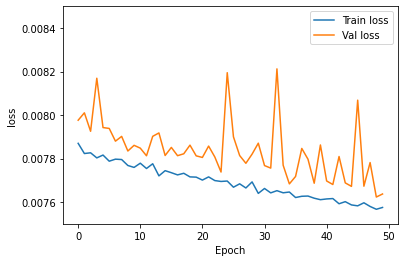

In [29]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('loss')
  plt.plot(hist['epoch'], hist['loss'],
           label='Train loss')
  plt.plot(hist['epoch'], hist['val_loss'],
           label = 'Val loss')
  plt.ylim([0.0075,0.0085])
  plt.legend()

  plt.show()


plot_history(history)

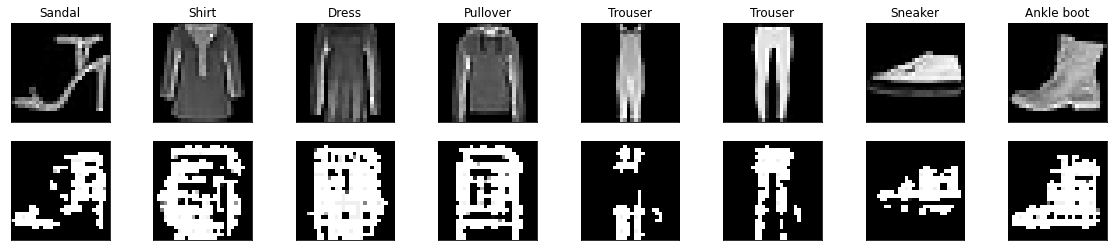

In [48]:
decoded_imgs = autoencoder.predict(X_test)
n = 10
plt.figure(figsize=(20, 4))
for i, num in enumerate(randint(X_test.shape[0], size=8)): 
    # Display original
    ax = plt.subplot(2, 8, i+1)
    plt.imshow(X_test[num].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    ax.set_title(get_key(labels, y_test[num]))

    # Display reconstruction
    ax = plt.subplot(2, 8, i+9)
    plt.imshow(decoded_imgs[num].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

Con este codigo se puede generar nuevas prendas de vestir

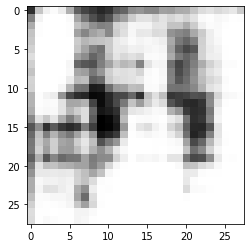

In [137]:
g = tf.random.Generator.from_non_deterministic_state()
#esta funcion es un generador inicializando su estado de forma no determinista.
random_latent_space = g.normal(shape=(1, 64))
ropa_random = decoder(random_latent_space)
imagen_ropa_random = tf.reshape(ropa_random, [28,28])
plt.imshow(imagen_ropa_random, cmap=plt.cm.binary)

espacio latente

In [159]:
encoded_images_test = encoder(test_images)

In [160]:
encoded_images_test

<tf.Tensor: shape=(10000, 64), dtype=float32, numpy=
array([[ 7.8507096e-01, -1.2940990e+00,  8.4091425e-03, ...,
         2.6332545e+00, -1.2203434e+00,  7.2880526e+00],
       [ 1.8652931e-01, -4.1004176e+00, -2.9836106e-01, ...,
         8.5417837e-01, -1.1721896e+00,  9.1139393e+00],
       [-2.7394757e+00,  3.0468914e-01,  2.7285247e+00, ...,
        -1.3926351e+00,  1.2123682e+00, -2.7134275e+00],
       ...,
       [-7.4364179e-01, -1.1804909e+00,  8.6582571e-01, ...,
        -4.1190201e-01, -2.4887921e-01,  3.6748242e+00],
       [-3.9801151e-01, -1.6857641e+00,  4.5496419e-02, ...,
         9.8225760e-01,  4.3373340e-01, -1.2570817e+00],
       [ 4.5075625e-01, -4.2879307e-01, -1.0854988e+00, ...,
         7.5219804e-01,  2.7978575e-01,  4.1379681e+00]], dtype=float32)>

In [148]:
test_images_labels = [get_key(labels, num) for num in y_test]

test_images_labels[0:10] #primeras 10


['Ankle boot',
 'Pullover',
 'Trouser',
 'Trouser',
 'Shirt',
 'Trouser',
 'Coat',
 'Shirt',
 'Sandal',
 'Sneaker']